In [77]:
import pandas as pd

dataframe = pd.read_csv('dataset.csv')
dataframe.head()

,Unnamed: 0,Name,Description,Importance
0,0,Complete Work Assignment,Finish assigned tasks by the deadline for proj...,10
1,1,Read Book,Read ‘Atomic Habits’ to gain insights into hab...,4
2,2,Join Industry Association,Become a member of a relevant professional ass...,6
3,3,Reflect on Personal Goals,Journal and reassess personal development goal...,5
4,4,Task: Conduct Survey,Organize customer satisfaction survey distribu...,7


In [78]:
task_names = dataframe["Name"]
task_descriptions = dataframe["Description"]
importances = dataframe["Importance"]
print(len(task_names))

20000


In [79]:
concatenated = [str(task_names[i]).lower() + " " + str(task_descriptions[i]).lower() for i in range(len(task_names))]
print(concatenated[:2])

['complete work assignment   finish assigned tasks by the deadline for project completion. high priority work task.  ', 'read book   read ‘atomic habits’ to gain insights into habit formation which is beneficial for personal growth, though not immediately urgent.  ']


In [80]:
alphanumeric = []
for task in concatenated:
    new_task = ''.join([character if character.isalnum() else ' ' for character in task])
    alphanumeric.append(new_task)
print(alphanumeric[:2])

['complete work assignment   finish assigned tasks by the deadline for project completion  high priority work task   ', 'read book   read  atomic habits  to gain insights into habit formation which is beneficial for personal growth  though not immediately urgent   ']


In [81]:
tokens = []
for task in alphanumeric:
    tokens.append([word for word in task.split() if word != ''])
print(tokens[:5])

[['complete', 'work', 'assignment', 'finish', 'assigned', 'tasks', 'by', 'the', 'deadline', 'for', 'project', 'completion', 'high', 'priority', 'work', 'task'], ['read', 'book', 'read', 'atomic', 'habits', 'to', 'gain', 'insights', 'into', 'habit', 'formation', 'which', 'is', 'beneficial', 'for', 'personal', 'growth', 'though', 'not', 'immediately', 'urgent'], ['join', 'industry', 'association', 'become', 'a', 'member', 'of', 'a', 'relevant', 'professional', 'association', 'for', 'networking'], ['reflect', 'on', 'personal', 'goals', 'journal', 'and', 'reassess', 'personal', 'development', 'goals', 'for', 'the', 'year'], ['task', 'conduct', 'survey', 'organize', 'customer', 'satisfaction', 'survey', 'distribution', 'important', 'for', 'service', 'improvements']]


In [82]:
vocabulary = set()
for task in tokens:
    for token in task:
        vocabulary.add(token)
vocabulary = list(vocabulary)
print(len(vocabulary))

8040


In [83]:
import numpy as np

word2index = dict()
for i, w in enumerate(vocabulary):
    word2index[w] = i
indices = [np.asarray([word2index[token] for token in task]) for task in tokens]
print(indices[:5])

[array([3023, 2378, 5500,  175, 3499, 2939, 6782, 2389, 2294, 3047, 4144,
       7277, 4238, 7877, 2378, 4477]), array([ 893, 7288,  893, 2933, 2508, 1425, 5577, 7951, 7850, 5642, 2056,
       5763,  609, 1884, 3047, 3294, 4732,  152, 6727, 5460, 3153]), array([6780, 1881, 1602, 6359, 6408, 3475, 3198, 6408, 7370, 3593, 1602,
       3047,  240]), array([ 885, 2020, 3294, 5061, 3371, 3815, 2744, 3294, 7996, 5061, 3047,
       2389, 5384]), array([4477, 3673, 7969, 1264, 8018, 6229, 7969, 5473, 1325, 3047,  892,
       3164])]


In [84]:
from autograd import Tensor
from layers import Embedding, LSTMCell, MSELoss, Linear, Relu, Sequential
from optimisers import Adam

embedding = Embedding(vocab_size=len(vocabulary), dim=512)
model = Sequential([LSTMCell(n_inputs=512, n_outputs=512), LSTMCell(n_inputs=512, n_outputs=256), LSTMCell(n_inputs=256, n_outputs=128)])
output_layer = Sequential([Linear(n_inputs=128, n_outputs=256), Relu(), Linear(n_inputs=256, n_outputs=1)])

In [85]:
criterion = MSELoss()
optimiser = Adam(parameters=model.get_parameters() + embedding.get_parameters() + output_layer.get_parameters(), alpha=0.0001)

In [86]:
import random

random.shuffle(indices)

X_train = indices[:int(len(indices) * 0.7008)]
y_train = importances[:int(len(indices) * 0.7008)]

X_cv = indices[int(len(indices) * 0.7008):int(len(indices) * 0.8)]
y_cv = importances[int(len(indices) * 0.7008):int(len(indices) * 0.8)]

X_test = indices[int(len(indices) * 0.8):]
y_test = importances[int(len(indices) * 0.8):]

print(X_train[0].shape, len(X_train))

(13,) 14016


In [87]:
def predict(task_indices):
    hidden0 = model.layers[0].init_hidden()
    hidden1 = model.layers[1].init_hidden()
    hidden2 = model.layers[2].init_hidden()
    for t in range(len(task_indices)):
        input = Tensor([task_indices[t]], autograd=True)
        lstm_input = embedding.forward(input=input)
        hidden0 = model.layers[0].forward(input=lstm_input, hidden=hidden0)
        hidden1 = model.layers[1].forward(input=hidden0[0], hidden=hidden1)
        hidden2 = model.layers[2].forward(input=hidden1[0], hidden=hidden2)
    output = output_layer.forward(hidden2[0])
    
    return output

In [88]:
def cv_loss():
    total_loss = 0
    for task_i in range(len(X_cv)):
        output = predict(X_cv[task_i])
        output = output * Tensor(np.ones(output.data.shape), autograd=True)
        target = Tensor(np.array(y_cv)[task_i], autograd=True)
        loss = criterion.forward(output, target)
        total_loss += loss.data
    return total_loss / len(X_cv)

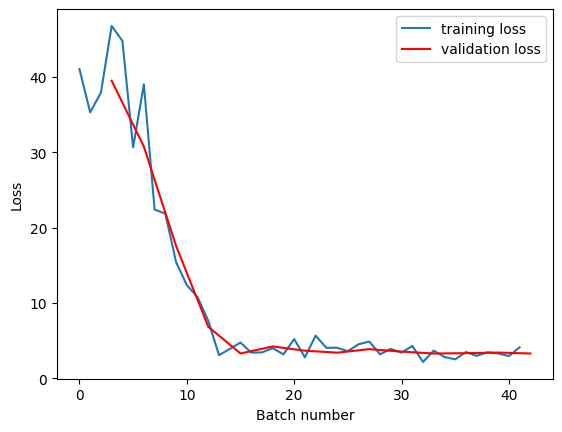

Training loss: 4.1107040864319 - Validation loss: [3.29086657]


KeyboardInterrupt: 

In [89]:
from matplotlib import pyplot as plt
from IPython import display

training_losses = []
cv_losses = []

min_loss = 1000
iterations = 100
timestep = 0
batch_size = 32
moment1 = [np.zeros(p.data.shape) for p in model.get_parameters() + embedding.get_parameters() + output_layer.get_parameters()]
moment2 = [np.zeros(p.data.shape) for p in model.get_parameters() + embedding.get_parameters() + output_layer.get_parameters()]
weight_decay = 0.001

for iteration in range(iterations):
    total_loss = Tensor(np.asarray(0), autograd=True)
    
    # Iterate through the training examples
    for task_i in range(0, len(X_train)):
        timestep += 1

        # Initialise the model before inference
        hidden0 = model.layers[0].init_hidden()
        hidden1 = model.layers[1].init_hidden()
        hidden2 = model.layers[2].init_hidden()
        
        # Iterate through each token in the current training example
        for t in range(len(X_train[task_i])):
            input = np.zeros(shape=(1,len(vocabulary)))
            input[0, X_train[task_i][t]] = 1
            input = Tensor(input, autograd=True)
            lstm_input = embedding.forward(input=input)
            hidden0 = model.layers[0].forward(input=lstm_input, hidden=hidden0)
            hidden1 = model.layers[1].forward(input=hidden0[0], hidden=hidden1)
            hidden2 = model.layers[2].forward(input=hidden1[0], hidden=hidden2)
        
        # Get the output of the model
        output = output_layer.forward(hidden2[0])

        # Compute loss for the current training example
        target = Tensor(y_train[task_i], autograd=True)
        loss = criterion.forward(output, target)
        loss.data = loss.data.reshape(())
        
        # Accumulate loss for the current batch
        total_loss = total_loss + loss

        print(f"Epoch: {iteration + 1} - Alpha: {str(optimiser.alpha)[:5]} - Batch {task_i // 32 + 1}/{len(X_train) // 32} - Example {task_i + 1}/{len(X_train)}", end='\r')

        # If all training examples in this batch have been processed
        if (task_i + 1) % batch_size == 0:
            # Calculate the average loss
            total_loss = total_loss * Tensor(np.asarray(0.03125), autograd=True)

            training_losses.append(total_loss.data)

            # Add L2 regularisation
            for parameter in model.get_parameters() + embedding.get_parameters() + output_layer.get_parameters():
                if len(parameter.data.shape) == 1:  # 1D bias parameter
                    total_loss = total_loss + (parameter * parameter).sum(0) * Tensor(np.asarray(weight_decay), autograd=True)
                else:  # 2D parameter
                    total_loss = total_loss + (parameter * parameter).sum(1).sum(0) * Tensor(np.asarray(weight_decay), autograd=True)

            total_loss.backward()
            moment1, moment2 = optimiser.step(timestep, moment1, moment2)
            total_loss = Tensor(np.asarray(0), autograd=True)

        if (task_i + 1) % (batch_size * 3) == 0:
            cv_losses.append(cv_loss())
            display.clear_output()
            plt.plot(training_losses)
            plt.plot(range(3, len(cv_losses) * 3 + 1, 3), cv_losses, color="red")
            plt.xlabel("Batch number")
            plt.ylabel("Loss")
            plt.legend(["training loss", "validation loss"])
            plt.show()
            print("Training loss:", training_losses[-1], "- Validation loss:", cv_losses[-1])

In [213]:
for task_i in range(len(X_test)):
    output = predict(X_test[task_i])
    target = Tensor(np.array(y_test)[task_i], autograd=True)
    loss = criterion.forward(output, target)
    print(f"Task {task_i + 1}/{len(X_test)} - Loss: {loss.data}", end='\r')
    total_loss += loss.data / len(X_test[task_i])
loss_to_display = np.exp(total_loss / (task_i + 1))
print()
print(loss_to_display)

AttributeError: 'numpy.ndarray' object has no attribute 'autograd'

In [90]:
import pickle as pkl

with open("importance_embedding.pkl", "wb") as file:
    pkl.dump(embedding, file)

with open("importance_model.pkl", "wb") as file:
    pkl.dump(model, file)

with open("importance_output.pkl", "wb") as file:
    pkl.dump(output_layer, file)

with open("word2index.pkl", "wb") as file:
    pkl.dump(word2index, file)

In [10]:
import pickle as pkl

with open("importance_embedding.pkl", "rb") as file:
    embedding = pkl.load(file)

with open("importance_model.pkl", "rb") as file:
    model = pkl.load(file)

with open("importance_output.pkl", "rb") as file:
    output_layer = pkl.load(file)

with open("word2index.pkl", "rb") as file:
    word2index = pkl.load(file)